# Homework 1
***

We are going to work with the following dataset: fluid current in a tube.
Some statistics are collected for dataset, incl. mean, skewness, kurtosis, etc. We are predicting flow rate ('tohn/hour'). We need to build confidence and predictive intervals.

In [1]:
%matplotlib inline

import numpy as np
from sklearn import datasets, linear_model, preprocessing, model_selection
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
df = pd.read_csv('exxsol_data.csv', sep=';', header=(0))

There are 10 features and 1 label to predict:

In [3]:
print(df.columns.values)

['mean' 'std' 'skew' 'kurt' 'RMS' 'crest' 'freq_peak' 'shan' 'perm' 'temp'
 'tohn/hour']


In [4]:
y = df['tohn/hour']
freq_temp = df[['freq_peak','temp']]

Physics tells us that flow rate is a function of a frequency peak and temperature.

In [6]:
freq_temp, y = shuffle(freq_temp, y)

# split data into training and testing sets
#from sklearn.model_selection import train_test_split
#train_freq, test_freq, train_y, test_y = train_test_split(freq, y, train_size=0.7, random_state=2)

lr = linear_model.LinearRegression()
predicted = model_selection.cross_val_predict(
    lr, freq_temp, y.ravel(), cv=20)
score = model_selection.cross_val_score(lr, freq_temp, y,
                                         scoring='r2',cv=20)

## Q0: Build point estimate for mean r2 score and its deviation

In [7]:
import pandas as ps
from scipy import stats as st
from statsmodels.stats.weightstats import _zconfint_generic, _tconfint_generic

X = score
n = len(X)
X_mean = np.mean(X)
S_X = np.var(X, ddof=1)

_tconfint_generic(X_mean, np.sqrt(S_X), n - 1, 0.05, 'two-sided')

(0.6308187360560599, 1.008370073819271)

## Q1: Predicted is an array with predictions of the label y. Assuming, that $\sigma = 0.1$, compute 95% confidence and predictive interval for mean squared error. 

In [8]:
error = np.sqrt((y - predicted)**2)  
X_mean = np.mean(error)
sigma = 0.1
n = len(error)

confidence_int = _zconfint_generic(X_mean, 0.1, 0.05, 'two-sided')
predictive_int = _zconfint_generic(X_mean, sigma*(1+1/n), 0.05, 'two-sided')

print("confidence_int = ", confidence_int, "\n" + "predictive_int = ", predictive_int)

confidence_int =  (0.12607264361209825, 0.518065440520109) 
predictive_int =  (0.12579264875716395, 0.5183454353750434)


## Q2:  Compute 95% confidence and predicted intervals for mean squared error, assuming no knowledge about $\sigma$.

In [9]:
error = np.sqrt((y - predicted)**2) 
print(error)
X_mean = np.mean(error)
sigma = 0.1
n = len(error)
S_X = np.var(error, ddof=1)

confidence_int = _tconfint_generic(X_mean, np.sqrt(S_X), n-1, 0.05, 'two-sided')
predictive_int = _tconfint_generic(X_mean, np.sqrt(S_X)*(1+1/n), n-1, 0.05,'two-sided')

print("confidence_int = ", confidence_int,  "\n" + "predictive_int = ", predictive_int)


573    0.406659
592    0.396659
28     0.312112
382    0.424592
511    0.410784
         ...   
375    0.384889
692    0.168474
263    0.208680
391    0.395792
539    0.382617
Name: tohn/hour, Length: 700, dtype: float64
confidence_int =  (-0.15699128455398598, 0.8011293686861933) 
predictive_int =  (-0.15767565644915754, 0.8018137405813648)


We can use additional features and more complex model, e.g. ElasticNet.

In [10]:
y = df['tohn/hour']
X = df.drop(['tohn/hour'],axis=1)
X = preprocessing.scale(X)
X, y = shuffle(X, y)

encv = linear_model.ElasticNetCV(cv=10,max_iter=3000, n_alphas=10)
predicted_encv = model_selection.cross_val_predict(
    encv, X, y.ravel(), cv=20)
score_encv = model_selection.cross_val_score(encv,X, y.ravel(),
                                         scoring='r2',cv=20)

## Q3:  Compute 95% confidence interval for difference in means of mean squared error between 2 models, assuming no knowledge about $\sigma$.

In [11]:
error = np.sqrt((y - predicted)**2) 
error_encv = np.sqrt((y - predicted_encv)**2) 


n,m = len(error), len(error_encv)
X_mean, Y_mean = np.mean(error), np.mean(error_encv)
S_X, S_Y = np.var(error, ddof=1), np.var(error_encv, ddof=1)
S_P = ((n-1) * S_X + (m-1) * S_Y) / (n + m - 2)


_tconfint_generic(X_mean - Y_mean, 
                  np.sqrt(S_P), n + m - 2, 0.05, 'two-sided')


(-0.1730752718070354, 2.0309313320072406)

## Q4: Implement UCB1

In [41]:
class Model:
    def __init__(self, probability, init_mean=0):
        self.probability = probability
        self.mean = init_mean
        if init_mean > 0:
             self.sample_size = 1
        else:
             self.sample_size = 0
    
    def execute(self):
        return np.random.uniform(0,1) < self.probability

    def update(self, x):
        self.sample_size += 1
        self.mean = ((self.sample_size - 1)*self.mean + x) / self.sample_size
        
def experiment(model_probs, eps, total=1000):
    models = [Model(p, init_mean=0) for p in model_probs]
    rewards = np.zeros(total)

    num_times_explored = 0
    num_times_exploited = 0
    num_optimal = 0

    optimal_j = np.argmax([m.probability for m in models])
    print("optimal j:", optimal_j)
    
    for i in range(1,total):
        
        if np.random.uniform(0,1) < eps:
            num_times_explored += 1
            j = np.random.randint(len(models))
        else:
            num_times_exploited += 1
            j = np.argmax([m.mean + np.sqrt(2*np.log(i)/m.sample_size) if m.sample_size!=0 else np.nan for m in models])
            #j = np.argmax([m.mean + np.sqrt(2*np.log(i)/m.sample_size) for m in models])

        if j == optimal_j:
            num_optimal += 1
            
        # execute best model
        x = models[j].execute()

        # update rewards 
        rewards[i] = x

        # update the distribution for the executed model
        models[j].update(x)
        
    for m in models:
        print("mean estimate:", m.mean)
        
    # print total reward
    print("total reward earned:", rewards.sum())
    print("overall win rate:", rewards.sum() / total)
    print("num_times_explored:", num_times_explored)
    print("num_times_exploited:", num_times_exploited)
    print("num times selected optimal bandit:", num_optimal)

    # plot the results
    cumulative_rewards = np.cumsum(rewards)
    win_rates = cumulative_rewards / (np.arange(total) + 1)
    plt.plot(win_rates)
    plt.plot(np.ones(total)*np.max(model_probs))
    plt.show()

optimal j: 2
mean estimate: 0.27142857142857146
mean estimate: 0.5207547169811324
mean estimate: 0.7414114238410595
total reward earned: 7322.0
overall win rate: 0.7322
num_times_explored: 0
num_times_exploited: 9999
num times selected optimal bandit: 9664


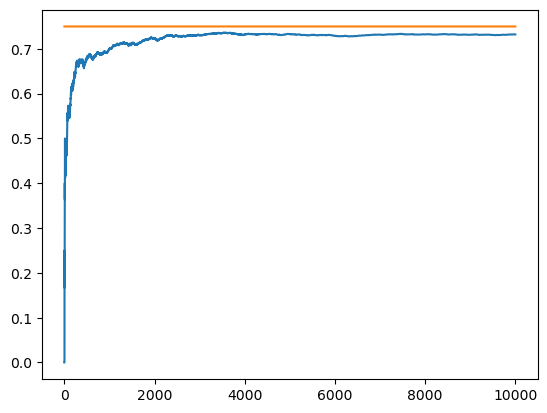

In [43]:
total = 10000
eps = 0
model_probs = [0.2, 0.5, 0.75]
experiment(model_probs, eps, total)